##### Copyright 2021 The TensorFlow Authors.

In [112]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple audio recognition: Recognizing keywords

This tutorial will show you how to build a basic speech recognition network that recognizes ten different words. It's important to know that real speech and audio recognition systems are much more complex, but like MNIST for images, it should give you a basic understanding of the techniques involved. Once you've completed this tutorial, you'll have a model that tries to classify a one second audio clip as "down", "go", "left", "no", "right", "stop", "up" and "yes".

## Setup

Import necessary modules and dependencies.

In [113]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
print(tf.version.VERSION)
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2.5.0


## Import the Speech Commands dataset

You'll write a script to download a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands). The original dataset consists of over 105,000 WAV audio files of people saying thirty different words. This data was collected by Google and released under a CC BY license.

You'll be using a portion of the dataset to save time with data loading. Extract the `mini_speech_commands.zip` and load it in using the `tf.data` API.

In [114]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

Moving wav files from command directories to unknown sub-directory (Factory Reset to reset data directory)


In [115]:
# comment out below line if "unknown" directory already exists
!mkdir /content/data/mini_speech_commands/unknown
# moves files from their specific commands directory to the "unknown" directory (replaces all files with an existing name therefore example set is smaller)
!mv /content/data/mini_speech_commands/down/* /content/data/mini_speech_commands/unknown
!rm -d /content/data/mini_speech_commands/down
!mv /content/data/mini_speech_commands/go/* /content/data/mini_speech_commands/unknown
!rm -d /content/data/mini_speech_commands/go
!mv /content/data/mini_speech_commands/left/* /content/data/mini_speech_commands/unknown
!rm -d /content/data/mini_speech_commands/left
!mv /content/data/mini_speech_commands/right/* /content/data/mini_speech_commands/unknown
!rm -d /content/data/mini_speech_commands/right
!mv /content/data/mini_speech_commands/stop/* /content/data/mini_speech_commands/unknown
!rm -d /content/data/mini_speech_commands/stop
!mv /content/data/mini_speech_commands/up/* /content/data/mini_speech_commands/unknown
!rm -d /content/data/mini_speech_commands/up
!rm /content/data/mini_speech_commands/README.md
!ls /content/data/mini_speech_commands/unknown | wc -l

mkdir: cannot create directory ‘/content/data/mini_speech_commands/unknown’: File exists
mv: cannot stat '/content/data/mini_speech_commands/down/*': No such file or directory
rm: cannot remove '/content/data/mini_speech_commands/down': No such file or directory
mv: cannot stat '/content/data/mini_speech_commands/go/*': No such file or directory
rm: cannot remove '/content/data/mini_speech_commands/go': No such file or directory
mv: cannot stat '/content/data/mini_speech_commands/left/*': No such file or directory
rm: cannot remove '/content/data/mini_speech_commands/left': No such file or directory
mv: cannot stat '/content/data/mini_speech_commands/right/*': No such file or directory
rm: cannot remove '/content/data/mini_speech_commands/right': No such file or directory
mv: cannot stat '/content/data/mini_speech_commands/stop/*': No such file or directory
rm: cannot remove '/content/data/mini_speech_commands/stop': No such file or directory
mv: cannot stat '/content/data/mini_speech_

Sets wanted commands for training (Available commands: Down, Go, Left, No, Right, Stop, Up, Yes, and Unknown for commands that are not to be tested

In [116]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = ["yes","no", "unknown"]
print('Commands:', commands)

Commands: ['yes', 'no', 'unknown']


Extract the audio files into a list and shuffle it.

In [117]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 5311
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/no/53458368_nohash_0.wav', shape=(), dtype=string)


Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.

In [118]:
# Take 80% of total number examples for training set files
train_files = filenames[:4249]
# Take 10% of total number examples adding to 80% of total examples for validation set files
val_files = filenames[4249: 4249 + 531]
# Take -10% of total number examples for test set files
test_files = filenames[-531:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 4249
Validation set size 531
Test set size 531


## Reading audio files and their labels

The audio file will initially be read as a binary file, which you'll want to convert into a numerical tensor.

To load an audio file, you will use [`tf.audio.decode_wav`](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav), which returns the WAV-encoded audio as a Tensor and the sample rate.

A WAV file contains time series data with a set number of samples per second. 
Each sample represents the amplitude of the audio signal at that specific time. In a 16-bit system, like the files in `mini_speech_commands`, the values range from -32768 to 32767. 
The sample rate for this dataset is 16kHz.
Note that `tf.audio.decode_wav` will normalize the values to the range [-1.0, 1.0].

In [119]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

The label for each WAV file is its parent directory.

In [120]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [121]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

You will now apply `process_path` to build your training set to extract the audio-label pairs and check the results. You'll build the validation and test sets using a similar procedure later on.

In [122]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Let's examine a few audio waveforms with their corresponding labels.

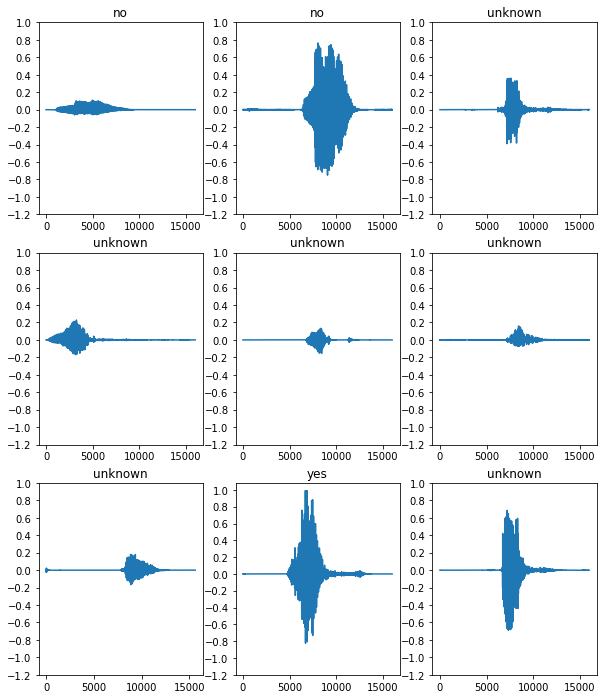

In [123]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Spectrogram

You'll convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.

A Fourier transform ([`tf.signal.fft`](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal to its component frequencies, but loses all time information. The STFT ([`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying `tf.abs` on the output of `tf.signal.stft`. 

Choose `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on STFT parameters choice, you can refer to [this video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing. 

You also want the waveforms to have the same length, so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.


In [124]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=480, frame_step=320, fft_length=512)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

Next, you will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.

In [125]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (49, 257)
Audio playback


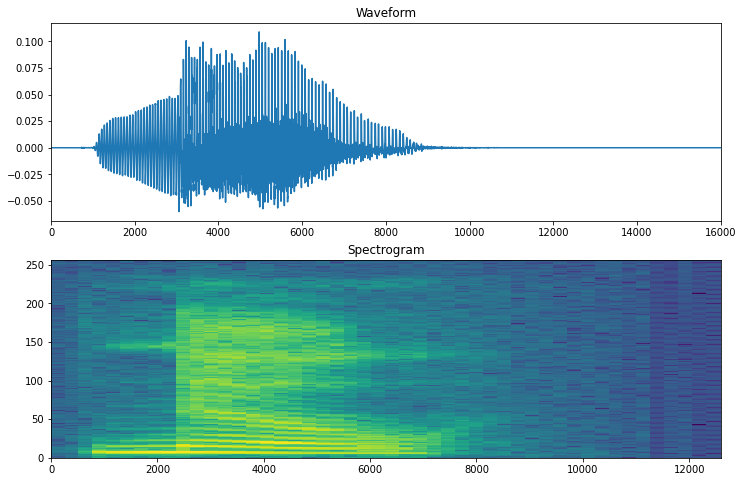

In [126]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [127]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [128]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)


Examine the spectrogram "images" for different samples of the dataset.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


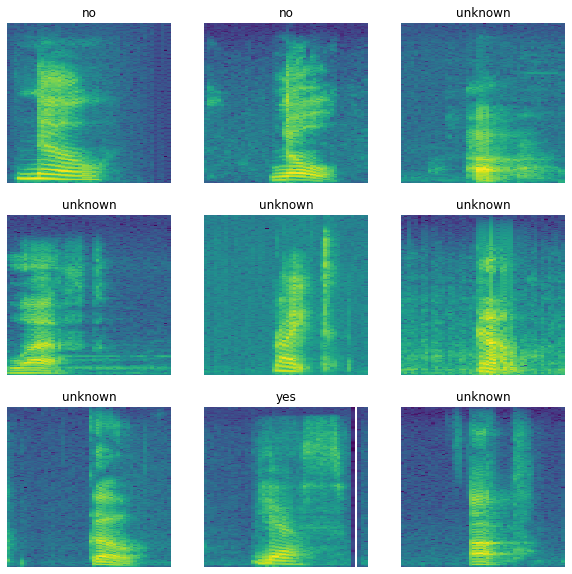

In [129]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

## Build and train the model

Now you can build and train your model. But before you do that, you'll need to repeat the training set preprocessing on the validation and test sets.

In [130]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [131]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)
print(val_ds)
print(test_ds)


<ParallelMapDataset shapes: ((None, 257, 1), ()), types: (tf.float32, tf.int64)>
<ParallelMapDataset shapes: ((None, 257, 1), ()), types: (tf.float32, tf.int64)>


Batch the training and validation sets for model training.

In [132]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.

In [133]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.
The model also has the following additional preprocessing layers:
- A [`Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer to downsample the input to enable the model to train faster.
- A [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [134]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)
print('num_labels:', num_labels)

model = models.Sequential([
    layers.Input(shape=(49, 257), name='input'),
    layers.Reshape(target_shape=(49, 257)),
    layers.LSTM(80, time_major=False, return_sequences=True),
    layers.Flatten(),
    layers.Dense(3, activation=tf.nn.softmax, name='output')
])
model.summary()

Input shape: (49, 257, 1)
num_labels: 3


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 49, 257)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 49, 80)            108160    
_________________________________________________________________
flatten_3 (Flatten)          (None, 3920)              0         
_________________________________________________________________
output (Dense)               (None, 3)                 11763     
Total params: 119,923
Trainable params: 119,923
Non-trainable params: 0
_________________________________________________________________


In [135]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [136]:
EPOCHS = 100
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
   # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/100
67/67 [==============================] - 10s 132ms/step - loss: 0.5685 - accuracy: 0.7677 - val_loss: 0.4034 - val_accuracy: 0.8249
Epoch 2/100
67/67 [==============================] - 0s 7ms/step - loss: 0.3422 - accuracy: 0.8647 - val_loss: 0.3415 - val_accuracy: 0.8663
Epoch 3/100
67/67 [==============================] - 0s 6ms/step - loss: 0.2520 - accuracy: 0.9028 - val_loss: 0.3160 - val_accuracy: 0.8908
Epoch 4/100
67/67 [==============================] - 0s 6ms/step - loss: 0.1916 - accuracy: 0.9303 - val_loss: 0.3530 - val_accuracy: 0.8814
Epoch 5/100
67/67 [==============================] - 0s 6ms/step - loss: 0.1372 - accuracy: 0.9525 - val_loss: 0.3112 - val_accuracy: 0.8964
Epoch 6/100
67/67 [==============================] - 0s 6ms/step - loss: 0.1110 - accuracy: 0.9598 - val_loss: 0.3256 - val_accuracy: 0.9021
Epoch 7/100
67/67 [==============================] - 0s 6ms/step - loss: 0.0946 - accuracy: 0.9635 - val_loss: 0.2767 - val_accuracy: 0.9153
Epoch 8/10

Let's check the training and validation loss curves to see how your model has improved during training.

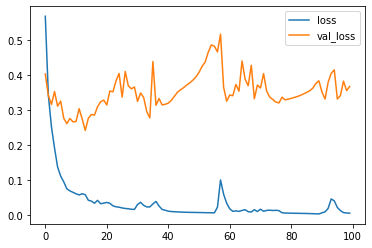

In [137]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluate test set performance

Let's run the model on the test set and check performance.

In [138]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [139]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 95%


### Display a confusion matrix

A confusion matrix is helpful to see how well the model did on each of the commands in the test set.

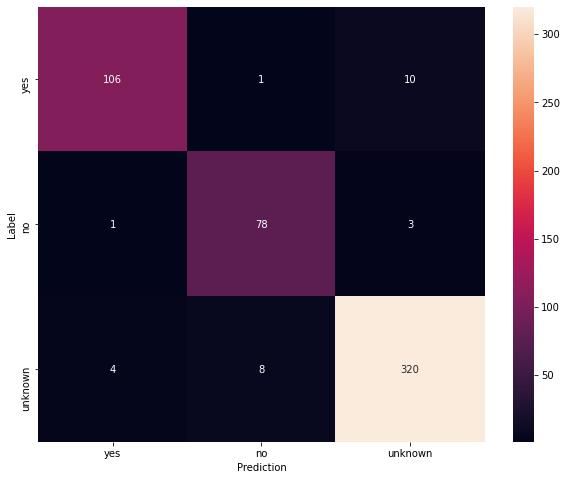

In [140]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "yes." How well does your model perform?

3
tf.Tensor([0.57611686 0.21194157 0.21194157], shape=(3,), dtype=float32)
tf.Tensor([[0.57611686 0.21194157 0.21194157]], shape=(1, 3), dtype=float32)


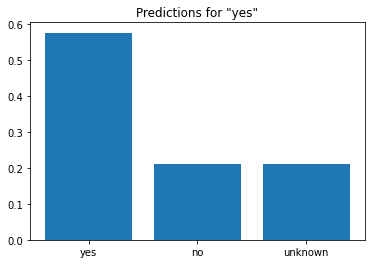

In [141]:
sample_file = '/content/data/mini_speech_commands/yes/0132a06d_nohash_1.wav'

sample_ds = preprocess_dataset([str(sample_file)])
for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  print(len(commands))
  print(tf.nn.softmax(prediction[0]))
  print(tf.nn.softmax(prediction))
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

You can see that your model very clearly recognized the audio command as "yes."

##Run TF inference on multiple audio files

/content/data/mini_speech_commands/unknown/4c77947d_nohash_0.wav


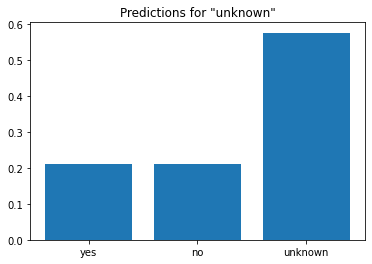

/content/data/mini_speech_commands/unknown/b737ee80_nohash_1.wav


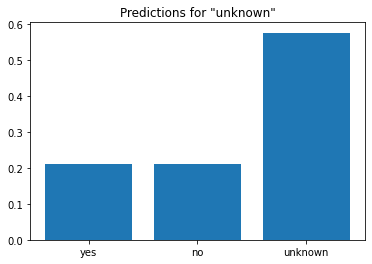

/content/data/mini_speech_commands/unknown/feb1d305_nohash_2.wav


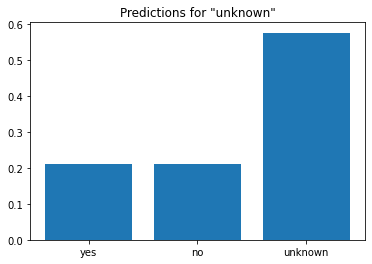

/content/data/mini_speech_commands/unknown/07ad9b59_nohash_2.wav


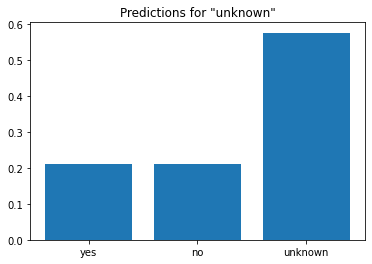

/content/data/mini_speech_commands/unknown/5c39594f_nohash_4.wav


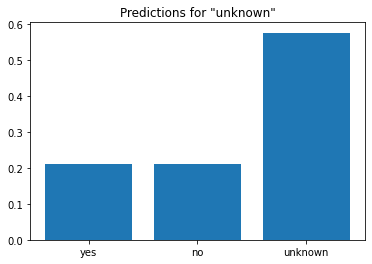

/content/data/mini_speech_commands/unknown/2d92f18b_nohash_0.wav


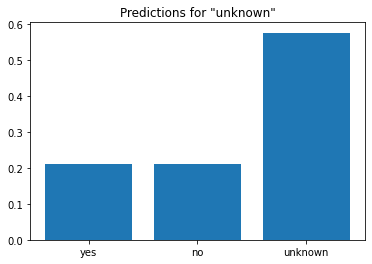

/content/data/mini_speech_commands/unknown/b83c1acf_nohash_2.wav


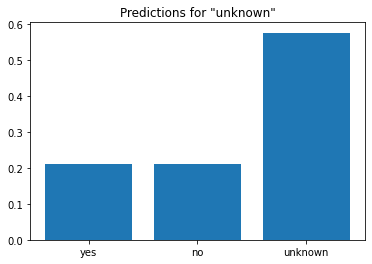

/content/data/mini_speech_commands/unknown/4a1e736b_nohash_4.wav


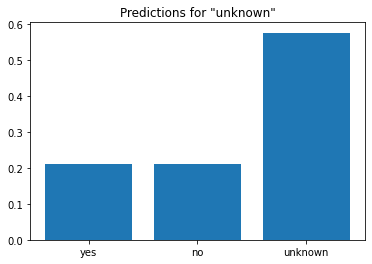

/content/data/mini_speech_commands/unknown/8012c69d_nohash_2.wav


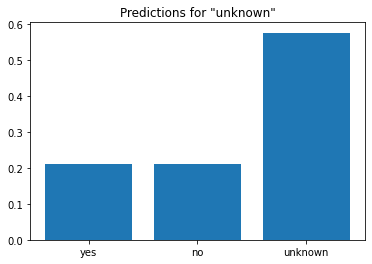

/content/data/mini_speech_commands/unknown/71f6fed7_nohash_2.wav


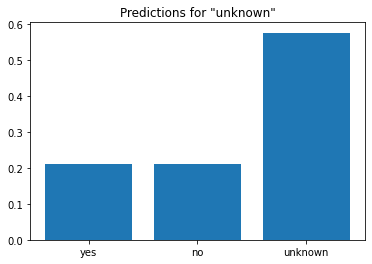

/content/data/mini_speech_commands/unknown/ec21c46b_nohash_2.wav


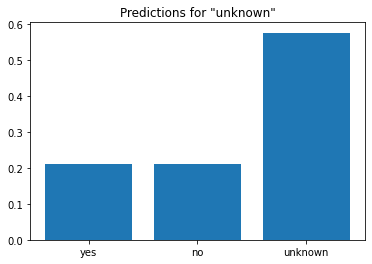

/content/data/mini_speech_commands/unknown/2f0a410b_nohash_1.wav


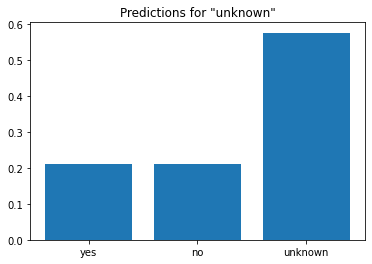

/content/data/mini_speech_commands/unknown/f2a90886_nohash_0.wav


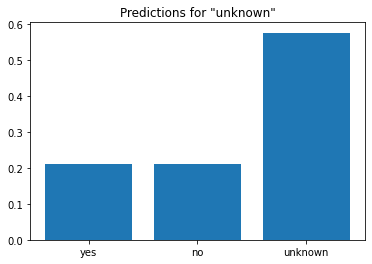

/content/data/mini_speech_commands/unknown/dbb40d24_nohash_0.wav


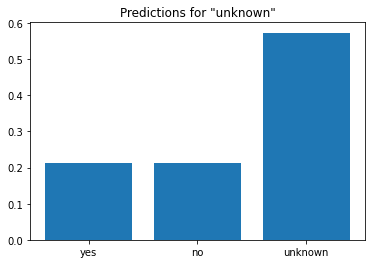

/content/data/mini_speech_commands/unknown/b9515bf3_nohash_1.wav


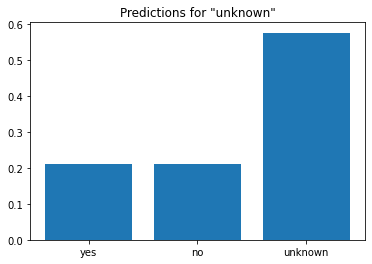

/content/data/mini_speech_commands/unknown/15c563d7_nohash_3.wav


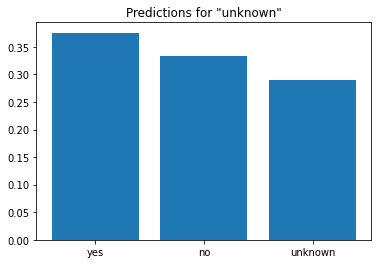

/content/data/mini_speech_commands/unknown/f4504600_nohash_1.wav


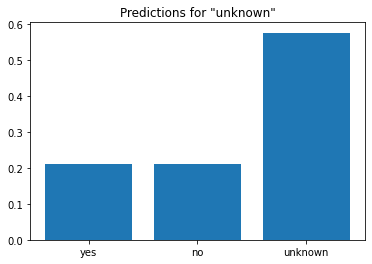

/content/data/mini_speech_commands/unknown/da76aa58_nohash_1.wav


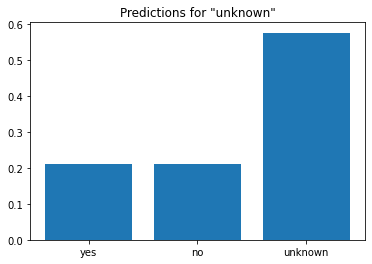

/content/data/mini_speech_commands/unknown/dedc7fab_nohash_1.wav


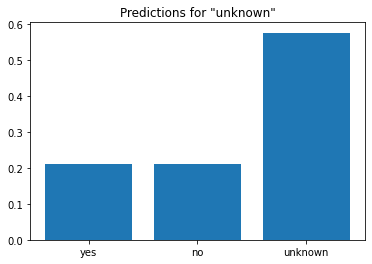

/content/data/mini_speech_commands/unknown/a527cb3c_nohash_0.wav


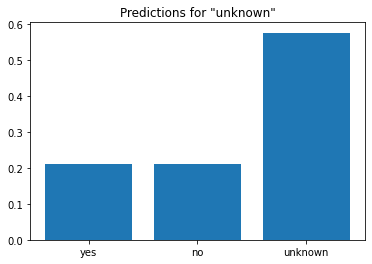

/content/data/mini_speech_commands/unknown/26b28ea7_nohash_0.wav


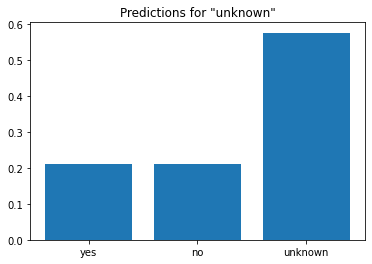

/content/data/mini_speech_commands/unknown/d84829e0_nohash_0.wav


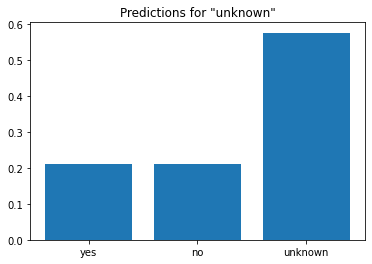

/content/data/mini_speech_commands/unknown/2313e093_nohash_0.wav


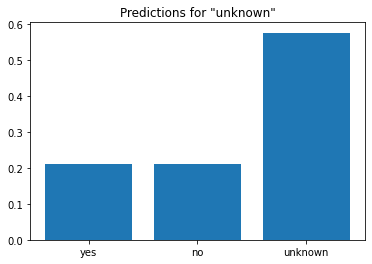

/content/data/mini_speech_commands/unknown/763188c4_nohash_1.wav


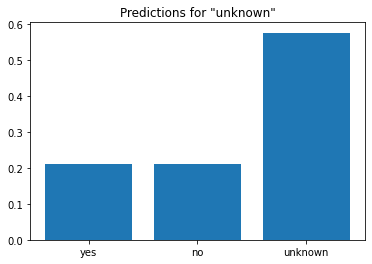

/content/data/mini_speech_commands/unknown/7ea032f3_nohash_3.wav


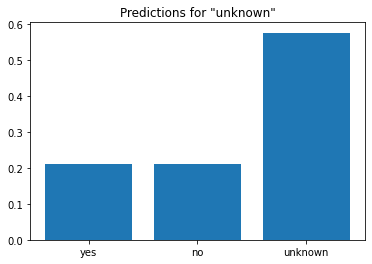

In [150]:
import glob
import pandas as pd
pd.set_option("display.precision", 2)

txtfiles = []
for file in glob.glob("/content/data/mini_speech_commands/unknown/*.wav"):
    txtfiles.append(file)

for i in range(25):
  print(txtfiles[i])
  sample_ds = preprocess_dataset([str(txtfiles[i])])
  for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()

##Generate TF Lite float32 model

In [143]:
import tensorflow
print(tensorflow.__version__)

run_model = tf.function(lambda x: model(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 49
INPUT_SIZE = 257

concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

# model directory.
MODEL_DIR = "keras_lstm"
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

#Float LSTM model
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_float_model = converter.convert()
open('/content/keras_lstm/model_float.tflite', "wb").write(tflite_float_model)


2.5.0


INFO:tensorflow:Assets written to: keras_lstm/assets


INFO:tensorflow:Assets written to: keras_lstm/assets


483000

##Validate audio files using TFLite float32 model

In [144]:
# Load quantized TFLite model
tflite_interpreter_float = tf.lite.Interpreter(model_path='/content/keras_lstm/model_float.tflite')
# Learn about its input and output details
input_details = tflite_interpreter_float.get_input_details()
output_details = tflite_interpreter_float.get_output_details()
tflite_interpreter_float.allocate_tensors()

import glob
import pandas as pd
pd.set_option("display.precision", 2)

txtfiles = []
for file in glob.glob("/content/data/mini_speech_commands/no/*.wav"):
    txtfiles.append(file)

for i in range(25):
  sample_ds = preprocess_dataset([str(txtfiles[i])])
  print(txtfiles[i])
  # Run inference
  for spectrogram, label in sample_ds.batch(1):
    tflite_interpreter_float.set_tensor(input_details[0]['index'],np.array(spectrogram, dtype=np.float32).reshape(1,49, 257) )
    tflite_interpreter_float.invoke()
    tflite_float_model_predictions = tflite_interpreter_float.get_tensor(output_details[0]['index'])
    # Convert prediction results to Pandas dataframe, for better visualization
    # Increase precision of presented data for better side-by-side comparison
    tflite_pred_dataframe = pd.DataFrame(tflite_float_model_predictions)
    tflite_pred_dataframe.columns = commands
    pd.set_option("precision",1)
    print(tflite_pred_dataframe)


/content/data/mini_speech_commands/no/5c39594f_nohash_4.wav
       yes   no  unknown
0  4.0e-13  1.0  5.8e-09
/content/data/mini_speech_commands/no/b83c1acf_nohash_2.wav
       yes   no  unknown
0  3.1e-08  1.0  7.1e-04
/content/data/mini_speech_commands/no/8012c69d_nohash_2.wav
       yes   no  unknown
0  2.1e-10  1.0  2.4e-10
/content/data/mini_speech_commands/no/dbb40d24_nohash_0.wav
       yes       no  unknown
0  1.1e-06  1.3e-06      1.0
/content/data/mini_speech_commands/no/f4504600_nohash_1.wav
       yes   no  unknown
0  1.9e-16  1.0  2.4e-13
/content/data/mini_speech_commands/no/c79159aa_nohash_4.wav
       yes   no  unknown
0  1.6e-11  1.0  6.5e-11
/content/data/mini_speech_commands/no/c7aa72e6_nohash_1.wav
       yes   no  unknown
0  4.3e-04  0.4      0.6
/content/data/mini_speech_commands/no/a527cb3c_nohash_0.wav
       yes   no  unknown
0  5.2e-12  1.0  1.6e-07
/content/data/mini_speech_commands/no/26b28ea7_nohash_0.wav
       yes   no  unknown
0  5.3e-08  1.0  2.7e-03
/c

##Generate Quantized int8 model


In [145]:
def representative_dataset_3():
  for spectrogram, _ in spectrogram_ds.take(800):
   # print('test')
    flattened_data = np.array(spectrogram, dtype=np.float32).reshape(1,49, 257)
    yield [flattened_data]

converter.representative_dataset = representative_dataset_3
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
quantized_tflite_model = converter.convert()
open('/content/keras_lstm/model_quantized_minispeech.tflite', "wb").write(quantized_tflite_model)


124768

##Validate Quantized int8 model

In [152]:

# Load quantized TFLite model
tflite_interpreter_quant = tf.lite.Interpreter(model_path='/content/keras_lstm/model_quantized_minispeech.tflite')
# Learn about its input and output details
input_details = tflite_interpreter_quant.get_input_details()

output_details = tflite_interpreter_quant.get_output_details()

tflite_interpreter_quant.allocate_tensors()

import glob
import pandas as pd
pd.set_option("display.precision", 2)

txtfiles = []
for file in glob.glob("/content/data/mini_speech_commands/unknown/*.wav"):
    txtfiles.append(file)

for i in range(25):
  print(txtfiles[i])
  sample_ds = preprocess_dataset([str(txtfiles[i])])
  # Run inference
  for spectrogram, label in sample_ds.batch(1):
    spectrogram_t = np.array(spectrogram, dtype=np.uint8).reshape(1,49, 257)
    spectrogram_t = np.array(spectrogram_t-128, dtype=np.int8)
    tflite_interpreter_quant.set_tensor(input_details[0]['index'],spectrogram_t )
    tflite_interpreter_quant.invoke()
    tflite_q_model_predictions = tflite_interpreter_quant.get_tensor(output_details[0]['index'])
    tflite_pred_dataframe = pd.DataFrame(tflite_q_model_predictions)
    tflite_pred_dataframe.columns = commands
    print(tflite_pred_dataframe)



/content/data/mini_speech_commands/unknown/4c77947d_nohash_0.wav
   yes   no  unknown
0 -128 -128      127
/content/data/mini_speech_commands/unknown/b737ee80_nohash_1.wav
   yes   no  unknown
0 -128 -128      127
/content/data/mini_speech_commands/unknown/feb1d305_nohash_2.wav
   yes   no  unknown
0 -128 -128      127
/content/data/mini_speech_commands/unknown/07ad9b59_nohash_2.wav
   yes   no  unknown
0 -128 -128      127
/content/data/mini_speech_commands/unknown/5c39594f_nohash_4.wav
   yes   no  unknown
0 -128 -127      127
/content/data/mini_speech_commands/unknown/2d92f18b_nohash_0.wav
   yes   no  unknown
0 -124 -124      120
/content/data/mini_speech_commands/unknown/b83c1acf_nohash_2.wav
   yes   no  unknown
0 -128 -128      127
/content/data/mini_speech_commands/unknown/4a1e736b_nohash_4.wav
   yes   no  unknown
0 -128 -128      127
/content/data/mini_speech_commands/unknown/8012c69d_nohash_2.wav
   yes   no  unknown
0 -128  127     -128
/content/data/mini_speech_commands/un

##Evaluate int8 model using floor and inputscale and zeropoint

In [147]:
#test
# Load quantized TFLite model
tflite_interpreter_quant_int8 = tf.lite.Interpreter(model_path='/content/keras_lstm/model_quantized_minispeech.tflite')
# Learn about its input and output details
input_details = tflite_interpreter_quant_int8.get_input_details()

output_details = tflite_interpreter_quant_int8.get_output_details()

tflite_interpreter_quant_int8.allocate_tensors()

import glob
import pandas as pd
pd.set_option("display.precision", 2)

txtfiles = []
for file in glob.glob("/content/data/mini_speech_commands/no/*.wav"):
    txtfiles.append(file)


for i in range(25):
  print(txtfiles[i])
  sample_ds = preprocess_dataset([str(txtfiles[i])])
  # Run inference
  for spectrogram, label in sample_ds.batch(1):
    input_scale, input_zero_point = input_details[0]["quantization"]
    print(input_scale)
    print(input_zero_point)
    spectrogram = np.array(spectrogram)
    spectrogram = np.clip(np.floor(spectrogram / input_scale + input_zero_point), -128, 127) # for int8 validation
    q_spectrogram = np.array(spectrogram, dtype=np.int8).reshape(1,49, 257)
    tflite_interpreter_quant_int8.set_tensor(input_details[0]['index'], q_spectrogram )
    tflite_interpreter_quant_int8.invoke()
    tflite_q_model_predictions = tflite_interpreter_quant_int8.get_tensor(output_details[0]['index'])
    print(tflite_q_model_predictions)
    output_scale, output_zero_point = output_details[0]["quantization"]
    tflite_model_predictions = (np.array(tflite_q_model_predictions, dtype=np.float32) - output_zero_point) * output_scale
    tflite_pred_dataframe = pd.DataFrame(tflite_model_predictions)
    tflite_pred_dataframe.columns = commands
    print(tflite_pred_dataframe)

/content/data/mini_speech_commands/no/5c39594f_nohash_4.wav
0.7175403237342834
-128
[[-128  127 -128]]
   yes   no  unknown
0  0.0  1.0      0.0
/content/data/mini_speech_commands/no/b83c1acf_nohash_2.wav
0.7175403237342834
-128
[[-128  125 -125]]
   yes    no  unknown
0  0.0  0.99     0.01
/content/data/mini_speech_commands/no/8012c69d_nohash_2.wav
0.7175403237342834
-128
[[-128  127 -128]]
   yes   no  unknown
0  0.0  1.0      0.0
/content/data/mini_speech_commands/no/dbb40d24_nohash_0.wav
0.7175403237342834
-128
[[-120 -128  120]]
    yes   no  unknown
0  0.03  0.0     0.97
/content/data/mini_speech_commands/no/f4504600_nohash_1.wav
0.7175403237342834
-128
[[-128  127 -128]]
   yes   no  unknown
0  0.0  1.0      0.0
/content/data/mini_speech_commands/no/c79159aa_nohash_4.wav
0.7175403237342834
-128
[[-128  127 -128]]
   yes   no  unknown
0  0.0  1.0      0.0
/content/data/mini_speech_commands/no/c7aa72e6_nohash_1.wav
0.7175403237342834
-128
[[-128  127 -127]]
   yes   no   unknown
0

##Generate a TensorFlow Lite for MicroControllers Model
Convert the TensorFlow Lite model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers.

In [148]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file
!xxd -i /content/keras_lstm/model_quantized_minispeech.tflite > /content/keras_lstm/model.cc


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/grap